In [2]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
        
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 

In [73]:
# version = ['noisedad_nn5-identity-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0',
#            'noisedad-lof-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']

version = ['noisedad_nn5-*-sampling_ratio_0.1-anomaly_ratio_*-n_query_0']


result_dir = './results/MVTecAD/'
method = 'PatchCore'
log_dirs = np.concatenate([glob(os.path.join(result_dir,method,'*',v,'seed_0','log.txt')) for v in version])

df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    
    data = pd.DataFrame(data['test_metrics'][0]).iloc[0,:].reset_index()
    temp_df = data 
    
    temp_df['class'] = class_name 
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    temp_df['exp_name'] = log_dir.split('/')[-3].split('-')[0]
    
    
    df = pd.concat([df,temp_df])

df = df.melt(['index','class','anomaly_ratio','sampling_method','exp_name'])

# sampling method identity,랑 lof만 남기기 
df = df[(df['sampling_method'] =='identity') | (df['sampling_method'] =='lof')].reset_index(drop=True)

# 이름 바꾸기 
df.loc[df['sampling_method']=='identity','sampling_method'] = 'PatchCore'
df.loc[df['sampling_method']=='lof','sampling_method'] = 'SoftPatch'


#result = df.pivot_table(index=['exp_name','class','sampling_method','index'],columns=['variable','anomaly_ratio'],values='value')
result = df.groupby(['anomaly_ratio','exp_name','sampling_method','index'])['value'].mean().reset_index().pivot(index=['exp_name','sampling_method','anomaly_ratio'],columns='index',values='value')

df['index'] = df['index'].apply(lambda x : 'image_auroc' if x == 'img_level' else 'pixel_auroc')    

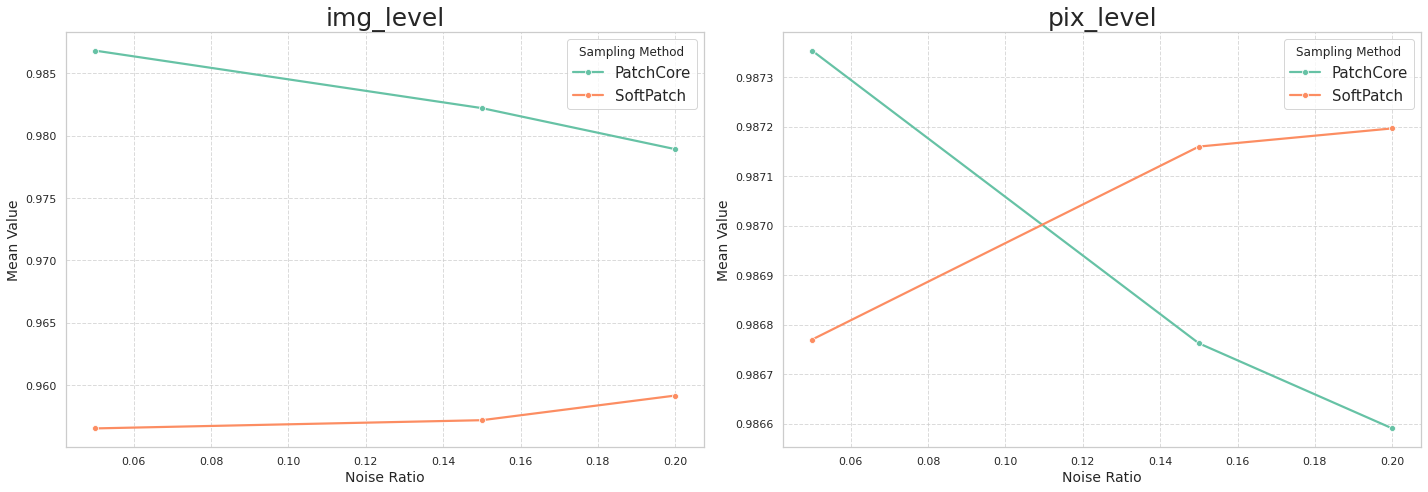

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set(style="whitegrid")  # Set the background style

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, a_type in enumerate(['img_level', 'pix_level']):
    sns.lineplot(
        x='anomaly_ratio',
        y='value',
        hue='sampling_method',
        data=df[df['index'] == a_type].reset_index(drop=True),
        ax=axes[i],
        linewidth=2.2,
        markers=True,  # Show markers at data points
        marker='o',    # Marker style
        palette='Set2',  # Color palette
        errorbar=None  # Disable confidence intervals
    )
    axes[i].legend(fontsize=15, title='Sampling Method')
    axes[i].set_title(f"{a_type}", size=25)
    axes[i].set_xlabel("Noise Ratio", size=14)
    axes[i].set_ylabel("Mean Value", size=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


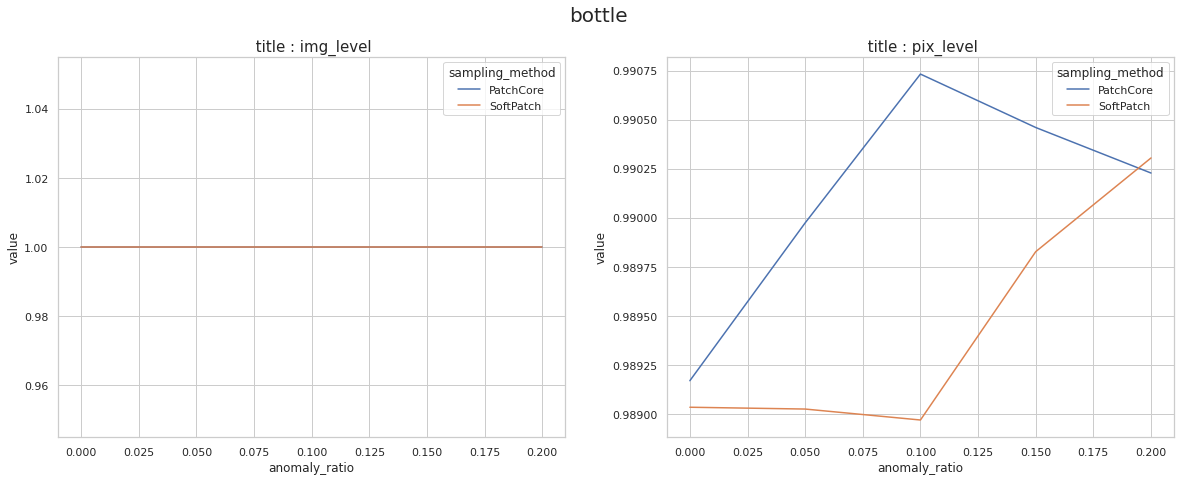

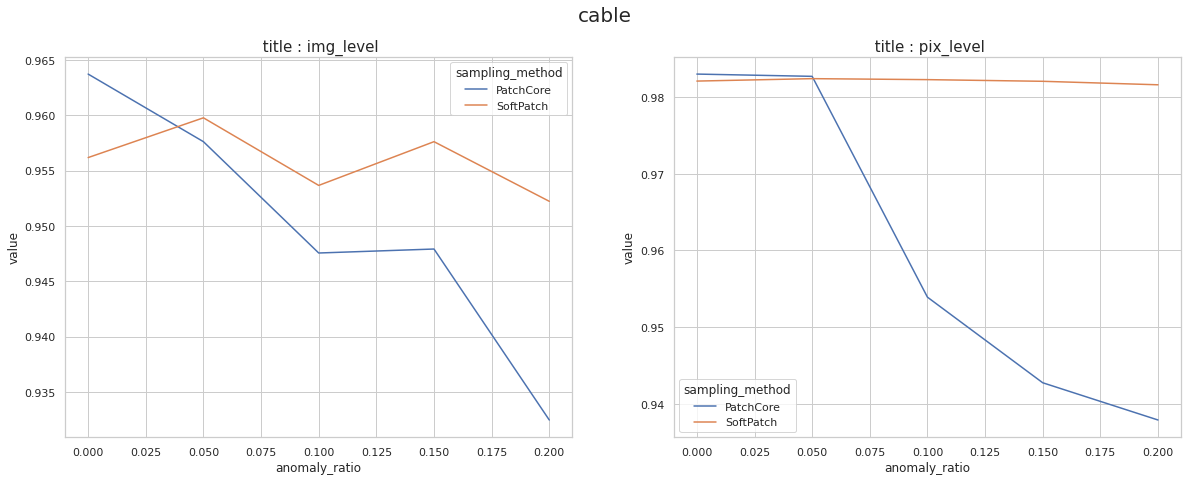

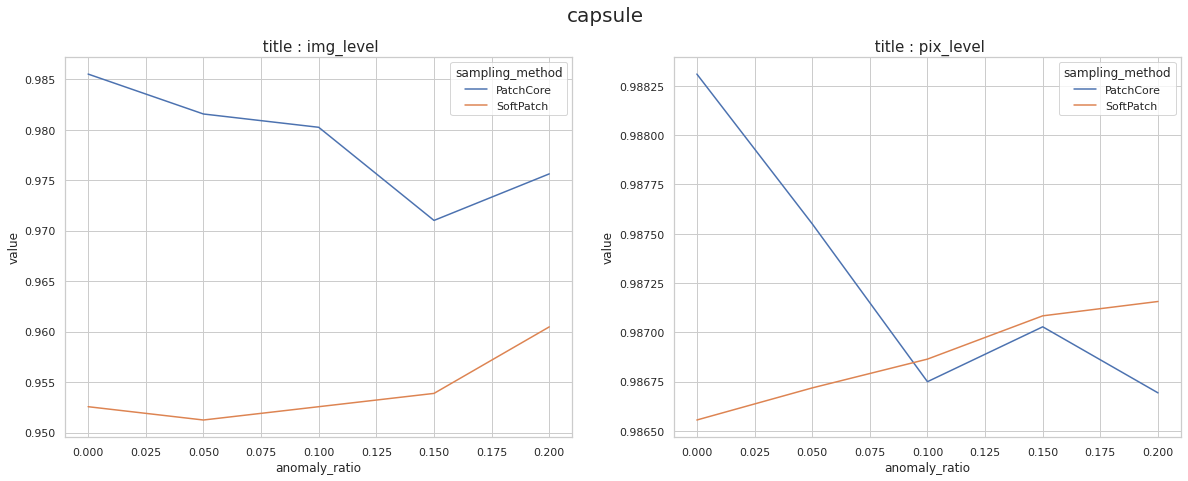

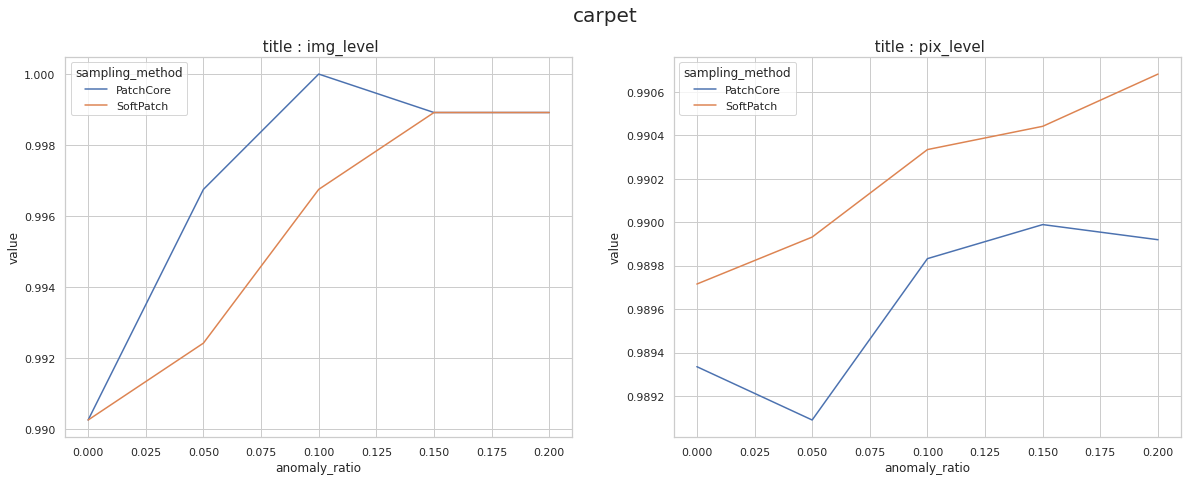

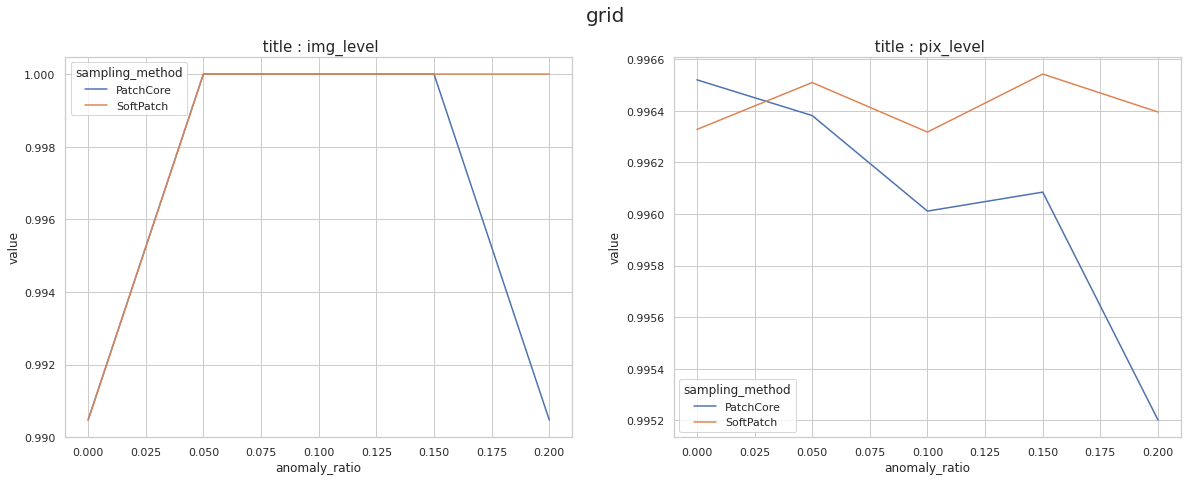

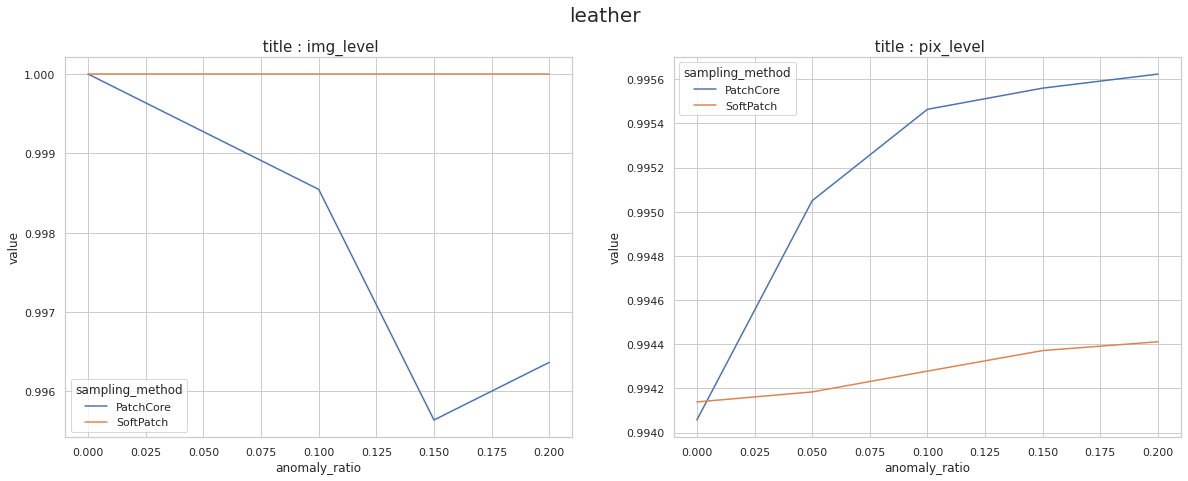

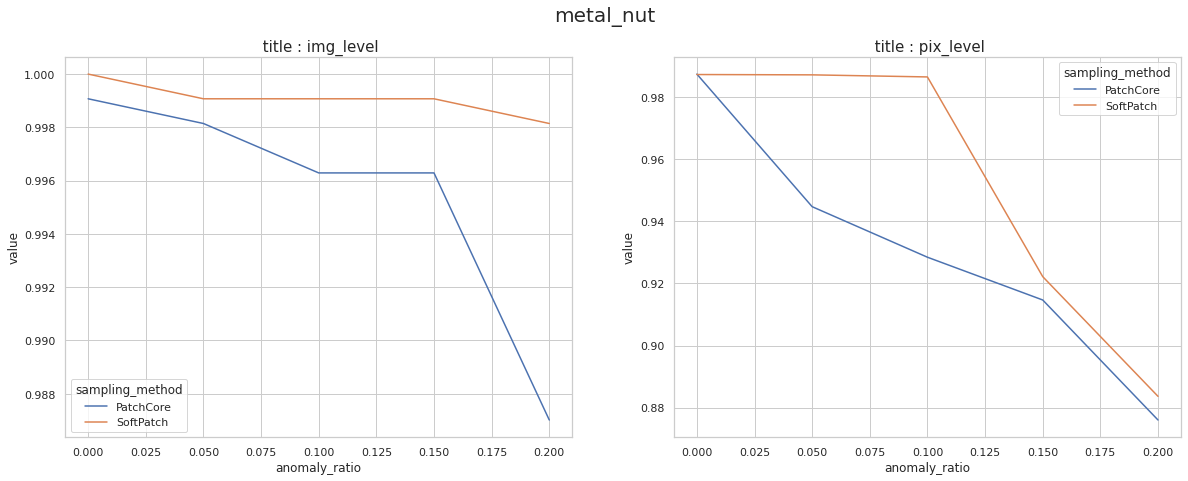

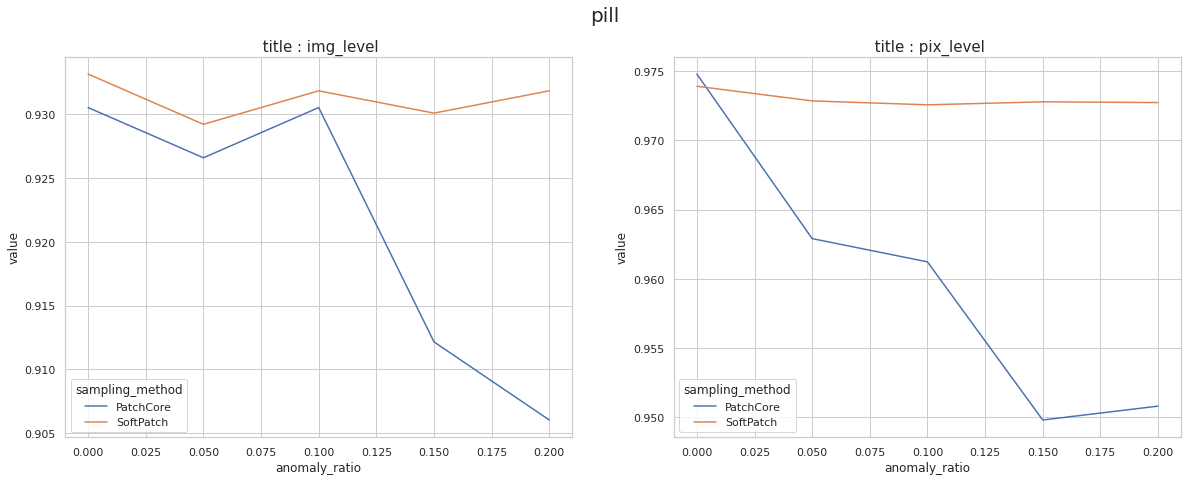

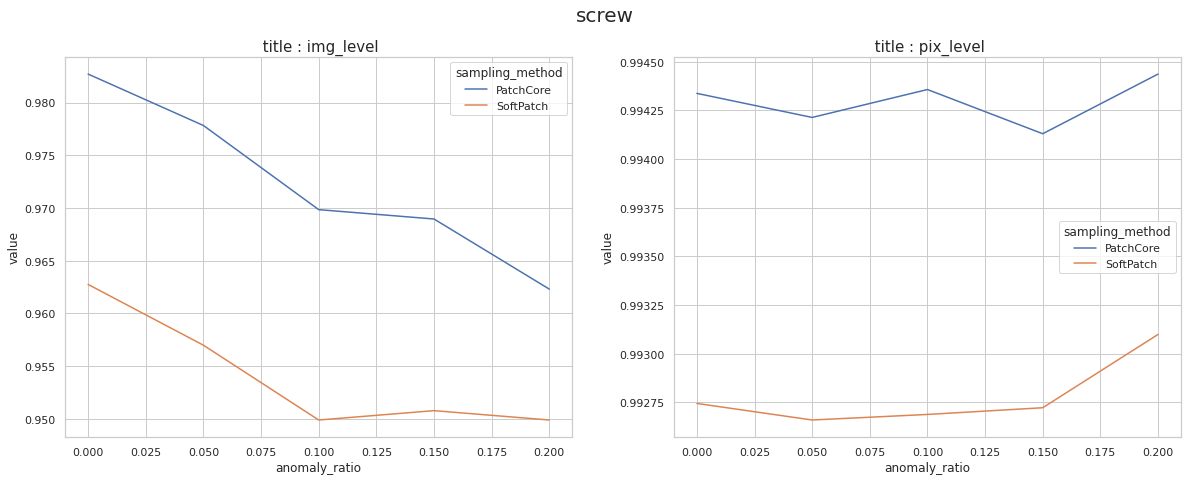

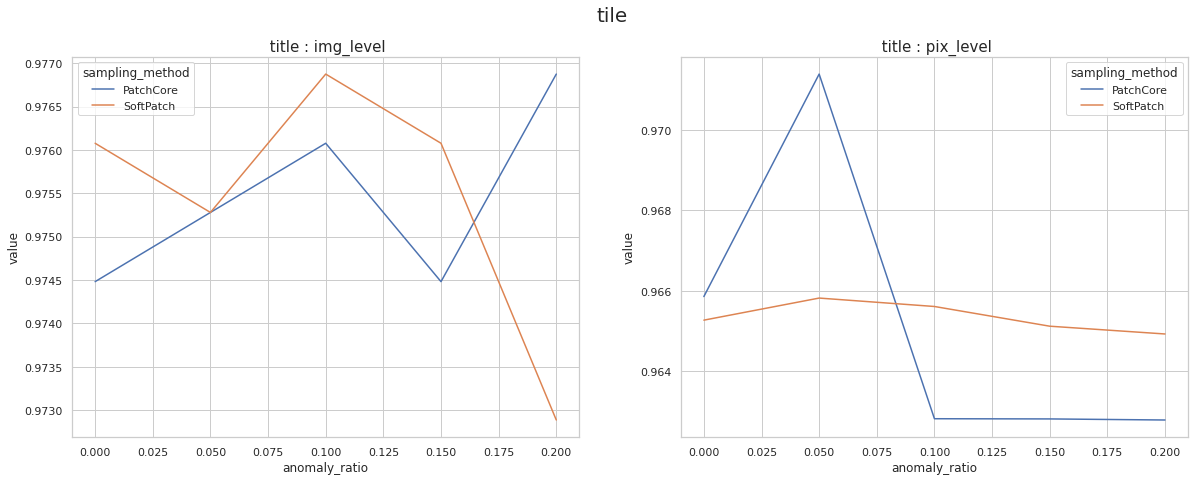

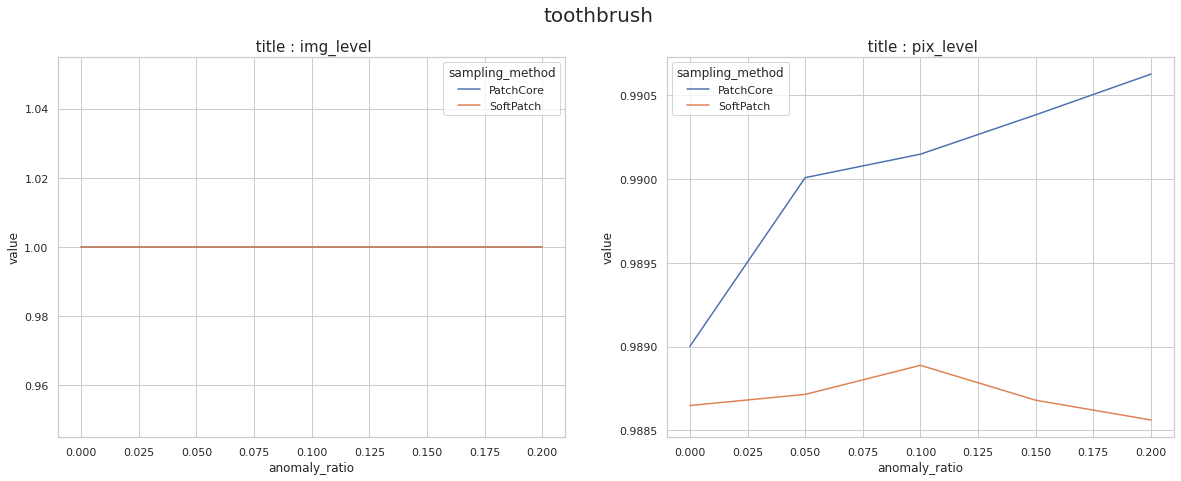

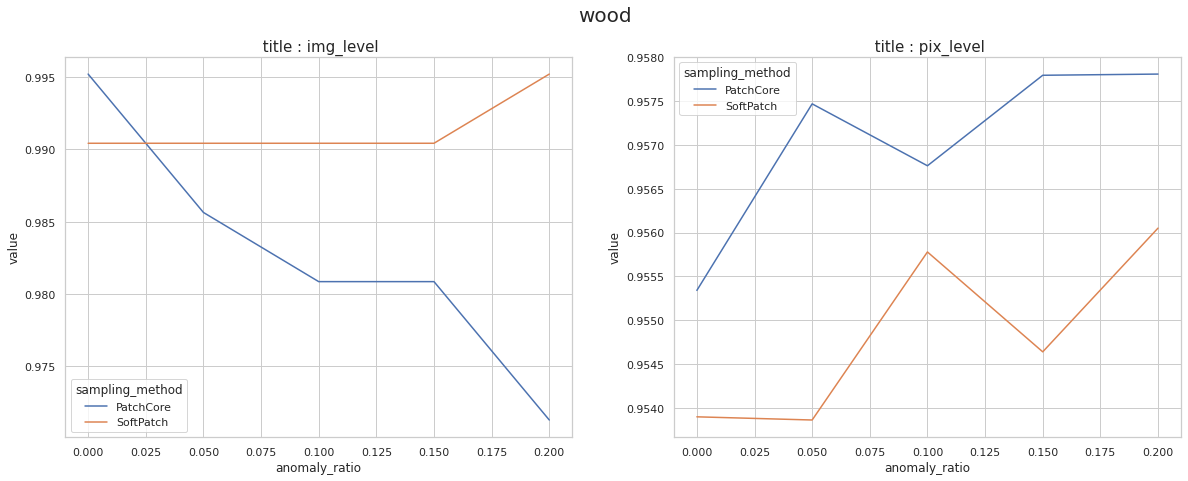

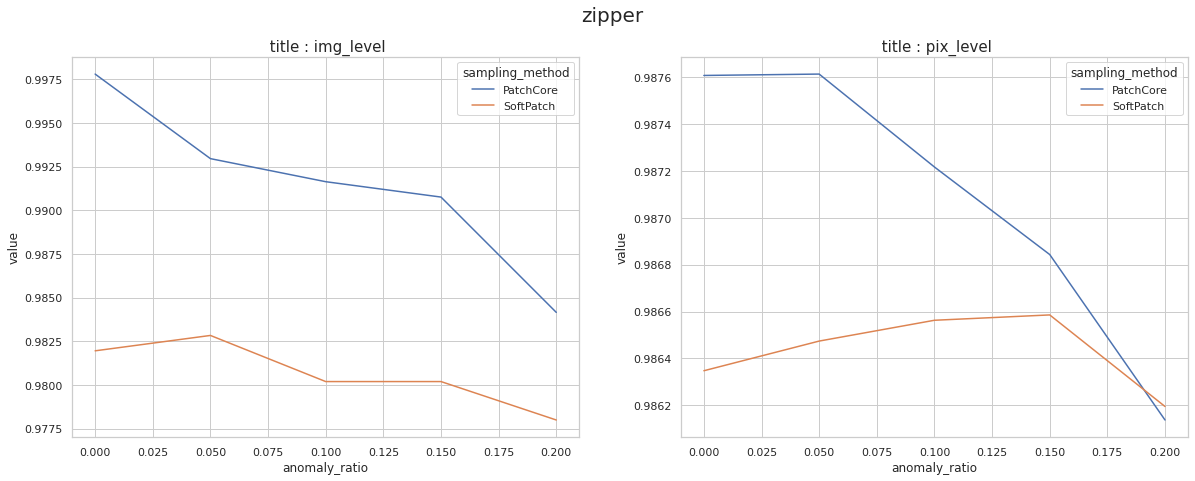

In [144]:
plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index','class'])['value'].mean().reset_index()

for class_name in plot_df['class'].unique():
    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['img_level','pix_level']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['index'] == a_type) & (plot_df['class']==class_name)],
            ax = axes[i]
        )   
        
        axes[i].set_title(f" title : {a_type}",size=15)
    fig.suptitle(class_name,size=20)
    
    plt.show()


In [145]:
pivot_df = plot_df.pivot_table(index=['sampling_method','index'],columns=['class','anomaly_ratio'],values='value')
pivot_df = pivot_df.loc['PatchCore'].values - pivot_df.loc['SoftPatch']

img_pivot = pivot_df.loc['img_level'].reset_index()
img_pivot['index']= 'img_level'
img_pivot.columns = ['class','anomaly_ratio','value','index']

pix_pivot = pivot_df.loc['pix_level'].reset_index()
pix_pivot['index']= 'pix_level'
pix_pivot.columns = ['class','anomaly_ratio','value','index']
pivot_df = pd.concat([img_pivot,pix_pivot])

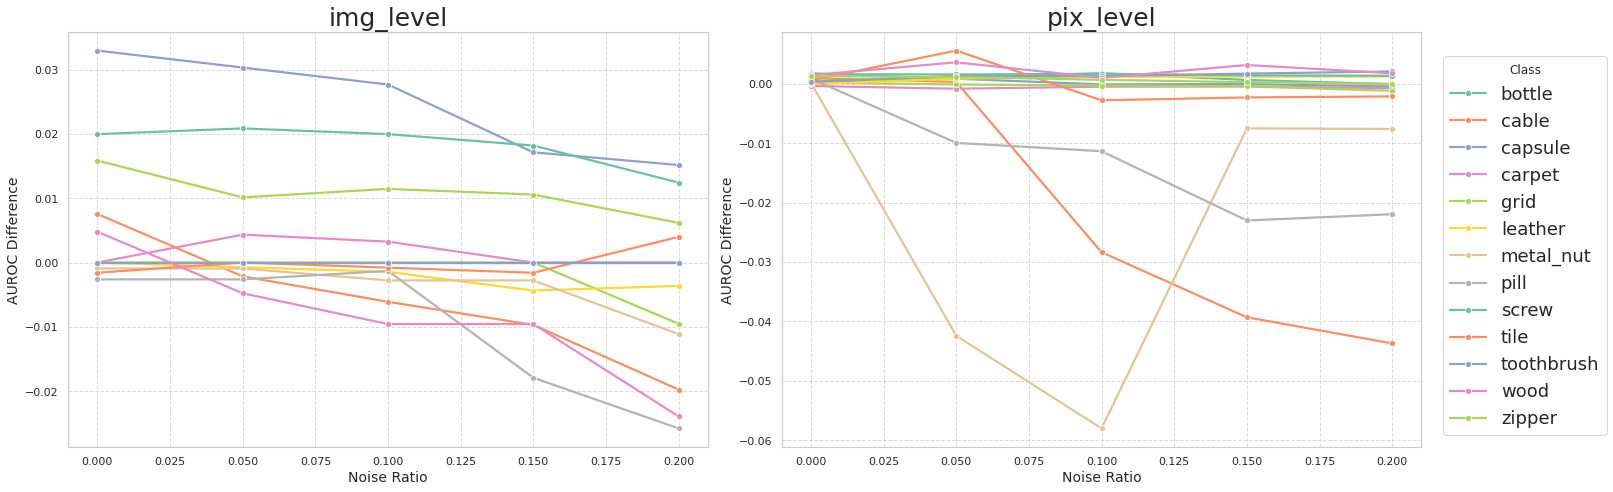

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing DataFrame and code
# ...

# Styling
sns.set(style="whitegrid")  # Set the background style

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, a_type in enumerate(['img_level', 'pix_level']):
    sns.lineplot(
        x='anomaly_ratio',
        y='value',
        hue='class',
        data=pivot_df[pivot_df['index'] == a_type],
        linewidth=2.2,
        markers=True,  # Show markers at data points
        marker='o',    # Marker style
        palette='Set2',  # Color palette
        errorbar=None,  # Disable confidence intervals,
        ax = axes[i]
    )
    axes[i].set_title(f"{a_type}", size=25)
    axes[i].set_xlabel("Noise Ratio", size=14)
    axes[i].set_ylabel("AUROC Difference", size=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].legend().set_visible(False)

# Adjust legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=18, title='Class', bbox_to_anchor=(1.0, 0.5), loc='center left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [154]:
pivot_df[(pivot_df['index']=='img_level') & (pivot_df['class']=='wood')]

,class,anomaly_ratio,value,index
55,wood,0.00,0.004785,img_level
56,wood,0.05,-0.004785,img_level
57,wood,0.10,-0.009569,img_level
58,wood,0.15,-0.009569,img_level
59,wood,0.20,-0.023923,img_level


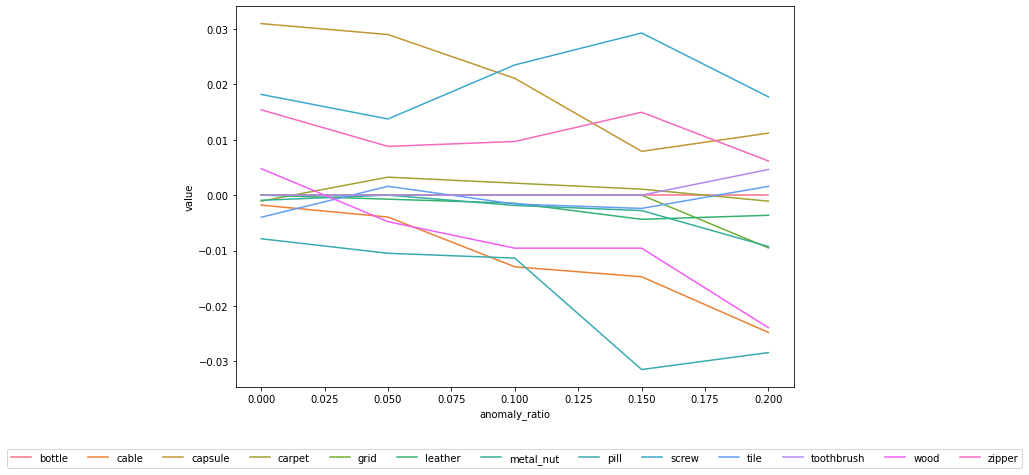

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have pivot_df defined
plt.figure(figsize=(10, 7))
sns.lineplot(
    x='anomaly_ratio',
    y='value',
    hue='class',
    data=pivot_df[pivot_df['index'] == 'img_level']
)

# Place legend below the figure in a horizontal layout
plt.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=len(pivot_df['class'].unique()))
plt.show()


# Noiseless 비교 

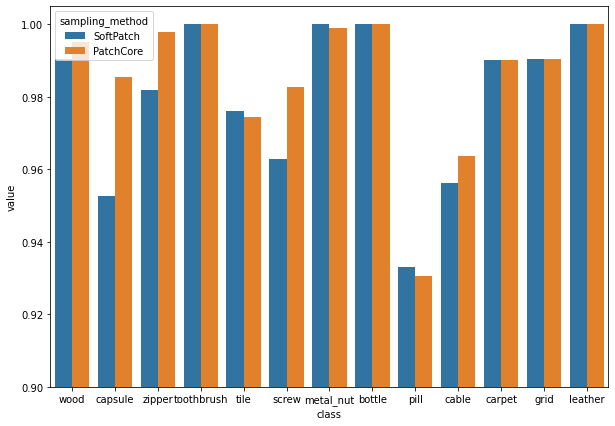

In [23]:
plot_df = df[df['anomaly_ratio']==0.00].reset_index(drop=True)

plt.figure(figsize=(10,7))
sns.barplot(
    x = 'class',
    y = 'value',
    hue = 'sampling_method',
    data = plot_df[plot_df['index']=='img_level']
)


plt.ylim(0.9,1.005)
plt.show()


In [31]:
glob('../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/*')

['../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/034',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/017',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/125',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/083',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/025',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/039',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/033',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/090',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/016',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/048',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/098',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/005',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/069',
 '../Data/MVTecLoco/juice_bottle/ground_truth/logical_anomalies/072',
 '../Data/MVTecLoco/

In [33]:
pivot_df = df.pivot_table(index='sampling_method', columns=['anomaly_ratio'], values='value', aggfunc='first')
pivot_df.loc['difference'] = pivot_df.loc['PatchCore'] - pivot_df.loc['SoftPatch']
pivot_df

anomaly_ratio,0.00,0.05,0.10,0.15,0.20
sampling_method,,,,,
PatchCore,0.995215,0.985646,0.980861,0.980861,0.971292
SoftPatch,0.990431,0.990431,0.990431,0.990431,0.995215
difference,0.004785,-0.004785,-0.009569,-0.009569,-0.023923


# DAE 

In [11]:
with open('./results/MVTecAD/dae/directly_denoising_log.txt','r') as f: 
    data = f.readlines()

direct = pd.DataFrame([eval(d) for d in data])
direct.columns = ['class_name','anomaly_ratio','pixel_auroc','image_auroc']
direct['sampling_method'] = 'DAE-direct'
direct = direct.groupby(['class_name','anomaly_ratio','sampling_method','image_auroc','pixel_auroc']).mean().reset_index()

In [12]:
with open('./results/MVTecAD/dae/log.txt','r') as f: 
    data = f.readlines()

dae = pd.DataFrame([eval(d) for d in data])
dae.columns = ['class_name','anomaly_ratio','pixel_auroc','image_auroc']
dae['sampling_method'] = 'DAE-outlier'
dae = dae.groupby(['class_name','anomaly_ratio','sampling_method','image_auroc','pixel_auroc']).mean().reset_index()

# version = ['noisedad_nn5-identity-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0',
#            'noisedad-lof-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']

version = ['noisedad_nn5-*-sampling_ratio_0.1-anomaly_ratio_*-n_query_0']


result_dir = './results/MVTecAD/'
method = 'PatchCore'
log_dirs = np.concatenate([glob(os.path.join(result_dir,method,'*',v,'seed_0','log.txt')) for v in version])

df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    
    data = pd.DataFrame(data['test_metrics'][0]).iloc[0,:].reset_index()
    temp_df = data 
    
    temp_df['class'] = class_name 
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    temp_df['exp_name'] = log_dir.split('/')[-3].split('-')[0]
    
    
    df = pd.concat([df,temp_df])

df = df.melt(['index','class','anomaly_ratio','sampling_method','exp_name'])

# sampling method identity,랑 lof만 남기기 
df = df[(df['sampling_method'] =='identity') | (df['sampling_method'] =='lof')].reset_index(drop=True)

# 이름 바꾸기 
df.loc[df['sampling_method']=='identity','sampling_method'] = 'PatchCore'
df.loc[df['sampling_method']=='lof','sampling_method'] = 'SoftPatch'


#result = df.pivot_table(index=['exp_name','class','sampling_method','index'],columns=['variable','anomaly_ratio'],values='value')
result = df.groupby(['anomaly_ratio','exp_name','sampling_method','index'])['value'].mean().reset_index().pivot(index=['exp_name','sampling_method','anomaly_ratio'],columns='index',values='value')

df['index'] = df['index'].apply(lambda x : 'image_auroc' if x == 'img_level' else 'pixel_auroc')    

df = pd.merge(df[df['index']=='image_auroc'].reset_index(drop=True),df[df['index']=='pixel_auroc'].reset_index(drop=True),on=['class','anomaly_ratio','sampling_method'],how='outer')
df = df.drop(columns = ['index_x','exp_name_x','variable_x','index_y','exp_name_y','variable_y'])
df.columns = ['class_name','anomaly_ratio','sampling_method','image_auroc','pixel_auroc']



In [13]:
df = pd.concat([dae,df,direct]).reset_index(drop=True)

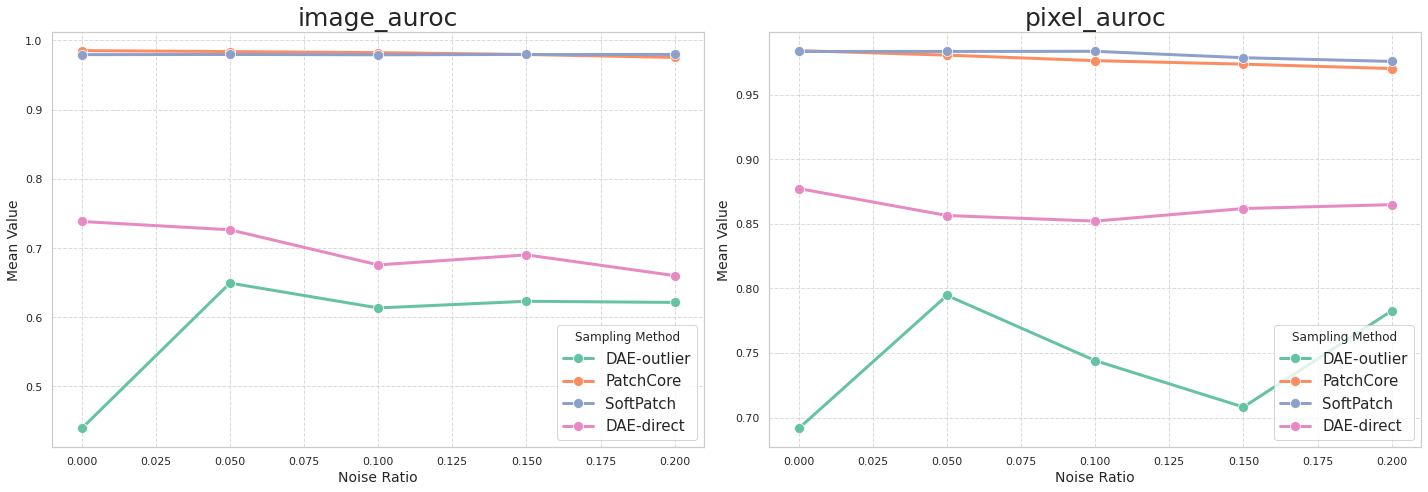

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set(style="whitegrid")  # Set the background style

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, a_type in enumerate(['image_auroc', 'pixel_auroc']):
    sns.lineplot(
        x='anomaly_ratio',
        y= a_type,
        hue='sampling_method',
        data=df,
        ax=axes[i],
        linewidth=3,
        markers=True,  # Show markers at data points
        marker='o',    # Marker style
        palette='Set2',  # Color palette
        markersize=10,
        errorbar=None  # Disable confidence intervals
    )
    axes[i].legend(fontsize=15, title='Sampling Method')
    title = 'Image AUROC' if a_type == 'image_auroc' else 'Pixel AUROC'
    axes[i].set_title(f"{a_type}", size=25)
    axes[i].set_xlabel("Noise Ratio", size=14)
    axes[i].set_ylabel("Mean Value", size=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean()

<ipython-input-6-6cb5b1604ef7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean()


image_auroc  pixel_auroc
sampling_method anomaly_ratio                          
DAE             0.00              0.439399     0.691593
                0.05              0.668515     0.784814
                0.10              0.639445     0.725578
                0.15              0.623119     0.708131
                0.20              0.621474     0.782657
PatchCore       0.00              0.985365     0.984209
                0.05              0.983971     0.980695
                0.10              0.982427     0.976434
                0.15              0.979768     0.973712
                0.20              0.975502     0.970319
SoftPatch       0.00              0.979525     0.983532
                0.05              0.979788     0.983561
                0.10              0.979328     0.983661
                0.15              0.979772     0.978695
                0.20              0.979813     0.975828

In [131]:
df

,class_name,anomaly_ratio,sampling_method,image_auroc,pixel_auroc
0,bottle,0.00,DAE,0.984091,0.970222
1,bottle,0.05,DAE,0.675,0.87565
2,bottle,0.10,DAE,0.55,0.862955
3,bottle,0.15,DAE,0.386364,0.86071
4,bottle,0.20,DAE,0.454545,0.854121
...,...,...,...,...,...
188,leather,0.05,SoftPatch,1.0,0.994184
189,leather,0.20,PatchCore,0.996366,0.995623
190,leather,0.15,PatchCore,0.99564,0.995559
191,leather,0.10,PatchCore,0.998547,0.995464


In [130]:
df.groupby(['anomaly_ratio','sampling_method','index'])['value'].mean().reset_index().pivot(index=['exp_name','sampling_method','anomaly_ratio'],columns='index',values='value')

index                                       img_level  pix_level
exp_name     sampling_method anomaly_ratio                      
noisedad_nn5 PatchCore       0.00            0.985365   0.984209
                             0.05            0.983971   0.980695
                             0.10            0.982427   0.976434
                             0.15            0.979768   0.973712
                             0.20            0.975502   0.970319
             SoftPatch       0.00            0.979525   0.983532
                             0.05            0.979788   0.983561
                             0.10            0.979328   0.983661
                             0.15            0.979772   0.978695
                             0.20            0.979813   0.975828